In [ ]:
!pip install transformers
!pip install accelerate -U

In [ ]:
import pandas as pd
import sklearn
from google.colab import drive
import nltk
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForSequenceClassification


drive.mount('/content/gdrive')

# Dataset
# repository https://github.com/iresiragusa/NLP/tree/main
# https://www.kaggle.com/datasets/yufengdev/bbc-fulltext-and-category?select=bbc-text.csv
# scarichiamo il dataset e lo carichiamo su COLAB

root = "/content/gdrive/MyDrive/Colab Notebooks/torch/"
df = pd.read_csv(root+"data/BBC-text/bbc-text.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# associo ad ogni categoria un indice, così ho delle label numeriche
labels_dict = {
    'business': 0,
    'politics': 1,
    'tech': 2,
    'sport': 3,
    'entertainment': 4
}

id_labels_dict = {
    0: 'business',
    1 : 'politics',
    2 : 'tech',
    3 : 'sport',
    4: 'entertainment'
}

df['labels'] = df.apply(lambda row: labels_dict[row.category], axis = 1)

In [ ]:
(x_train, x_test, y_train, y_test) = train_test_split(df['text'], df['labels'], test_size=0.2, random_state=17)

(x_train, x_val, y_train, y_val) = train_test_split( x_train, y_train, test_size=0.1, random_state=17)

In [ ]:
hyperparameters = {
    "epochs": 5,
    "learning_rate": 1e-3,
    "batch_size": 16,
    "dropout": 0.1,
    #"stopwords": True,
    "stopwords": False,
    "h_dim": 768,
    "patience": 5,
    "min_delta": 0.01,
    "language_model": "bert-base-uncased"
}

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, y, stopwords):

        if stopwords:
            tokens_litt = [nltk.word_tokenize(text, language='english') for text in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w for w in sentence if not w.lower() in nltk.corpus.stopwords.words("english")]))
        else:
            tokens_litt = [nltk.word_tokenize(text, language='english') for text in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                #sentence_clean = ' '.join([w.lower() for w in sentence])
                #text_clean.append(sentence_clean)
                text_clean.append(' '.join([w.lower() for w in sentence]))
            # ogni token è separato dall'altro con uno spazio
        self.texts = [text for text in text_clean]
        self.labels = [torch.tensor(label) for label in y]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_texts, batch_labels

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#creo i dataset

train_dataset = Dataset(x_train, y_train, hyperparameters["stopwords"])
val_dataset = Dataset(x_val, y_val, hyperparameters["stopwords"])
test_dataset = Dataset(x_test, y_test, hyperparameters["stopwords"])

Tokenizing ... : 100%|██████████| 445/445 [00:00<00:00, 12229.97it/s]


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
                                                                            # come nuova loss ottimale
            self.counter = 0                                                # e azzeriamo il contatore di pazienza

Invece di una rete scritta da noi, useremo un modello di huggingface per text classification.

Ogni modello/tokenizer può essere richiamato con la sua classe o tramite la autoclass, che automaticamente instanzia l'oggetto corrispondente al nome del modello:

```
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") #(1)
model = BertModel.from_pretrained("bert-base-uncased")
```

Dalla documentazione (https://huggingface.co/docs/transformers/index) potete vedere tutte le classi e i modelli disponibili. Per il caricamento di un modello via autoclass di cui conoscete il nome ma non l'esatta dicitura, per inserirla in (1), cercatlo su huggingface, da qua (https://huggingface.co/) inserendo il nome e si aprirà la scheda del modello con il nome per il caricamento sul codice python, con descrizione e codice di esempio (vedi RoBERTa il cui nome del modello da inserire nel codice è roberta-base https://huggingface.co/roberta-base)

In [ ]:
def train_loop(model, dataloader, tokenizer, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_labels in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()
        tokens = tokenizer(list(batch_texts), add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 512, truncation=True)
        input_id_texts = tokens['input_ids'].squeeze(1).to(device)
        mask_texts = tokens['attention_mask'].squeeze(1).to(device)
        batch_labels = batch_labels.to(device)

        output = model(input_id_texts, mask_texts).logits # .logits permette di prendere l'output desiderato dal modello

        # la loss è una CrossEntropyLoss, al suo interno ha la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni applicando manualmente la logsoftmax
        softmax = nn.LogSoftmax(dim=1)
        epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

        batch_labels = batch_labels.detach().cpu()
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [ ]:
def test_loop(model, dataloader, tokenizer, loss, device):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    with torch.no_grad():

        for batch_texts, batch_labels, in tqdm(dataloader, desc='dev set'):

            tokens = tokenizer(list(batch_texts), add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 512, truncation=True)
            input_id_texts = tokens['input_ids'].squeeze(1).to(device)
            mask_texts = tokens['attention_mask'].squeeze(1).to(device)
            batch_labels = batch_labels.to(device)
            output = model(input_id_texts, mask_texts).logits

            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            softmax = nn.LogSoftmax(dim=1)
            epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

            batch_labels = batch_labels.detach().cpu()
            input_id_texts = input_id_texts.detach().cpu()
            mask_texts = mask_texts.detach().cpu()
            output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [ ]:
def train_test(model, epochs, optimizer, device, train_data, test_data,
               batch_size, language_model, train_loss_fn, test_loss_fn=None,
               early_stopping=None, val_data=None, scheduler=None):

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    # check sulle funzioni di loss
    if test_loss_fn == None:
        test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []
    test_loss = []

    train_acc = []
    validation_acc = []
    test_acc = []

    tokenizer = AutoTokenizer.from_pretrained(language_model)

    # Ciclo di addestramento con early stopping
    for epoch in tqdm(range(1,epochs+1)):

        epoch_train_loss, epoch_train_acc = train_loop(model, train_dataloader, tokenizer, train_loss_fn, optimizer, device)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc/len(train_data))

        # validation se è presente la callback di early stopping
        if early_stopping != None:
                epoch_validate_loss, epoch_validate_acc = test_loop(model, val_dataloader, tokenizer, test_loss_fn, device)
                validation_loss.append(epoch_validate_loss)
                validation_acc.append(epoch_validate_acc/len(val_data))

        # test
        epoch_test_loss, epoch_test_acc,= test_loop(model, test_dataloader, tokenizer, test_loss_fn, device)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc/len(test_data))

        val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} ' if early_stopping != None else ' '
        val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '
        print(f"\nTrain loss: {epoch_train_loss:6.4f} {val_loss_str}Test loss: {epoch_test_loss:6.4f}")
        print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} {val_acc_str}Test accuracy: {(epoch_test_acc/len(test_data)):6.4f}")

        # early stopping
        if early_stopping != None:
                early_stopping(epoch_validate_loss)
                if early_stopping.early_stop:
                    break

    return train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc

In [ ]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

''' model = ClassifierDeep(len(labels_dict),
                    hyperparameters["h_dim"],
                    hyperparameters["dropout"],
                    ).to(device) '''


model_name = hyperparameters["language_model"]  # You can change this to any other supported model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels_dict)).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'],
                               min_delta=hyperparameters['min_delta'])


Using cuda device


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Routine di addestramento
train_loss, validation_loss,test_loss, train_acc, validation_acc, test_acc = train_test(model,
                                                hyperparameters['epochs'],
                                                #50,
                                                optimizer,
                                                device,
                                                train_dataset,
                                                test_dataset,
                                                hyperparameters['batch_size'],
                                                hyperparameters['language_model'],
                                                criterion,
                                                criterion,
                                                early_stopping,
                                                val_dataset)

training set: 100%|██████████| 101/101 [02:31<00:00,  1.50s/it]

dev set: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]

 20%|██        | 1/5 [02:52<11:28, 172.11s/it]


Train loss: 1.6988 Validation loss: 1.6547 Test loss: 1.6906
Train accuracy: 0.1998 Validation accuracy: 0.1966 Test accuracy: 0.1663



training set: 100%|██████████| 101/101 [02:31<00:00,  1.50s/it]

dev set: 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]

 40%|████      | 2/5 [05:43<08:35, 171.76s/it]


Train loss: 1.6945 Validation loss: 1.6350 Test loss: 1.6764
Train accuracy: 0.2066 Validation accuracy: 0.2247 Test accuracy: 0.2090



training set: 100%|██████████| 101/101 [02:31<00:00,  1.50s/it]

dev set: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]

 60%|██████    | 3/5 [08:35<05:43, 171.67s/it]


Train loss: 1.6775 Validation loss: 1.6537 Test loss: 1.6211
Train accuracy: 0.2116 Validation accuracy: 0.1685 Test accuracy: 0.2022



training set: 100%|██████████| 101/101 [02:31<00:00,  1.50s/it]

dev set: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]

 80%|████████  | 4/5 [11:27<02:51, 171.79s/it]


Train loss: 1.6958 Validation loss: 1.9191 Test loss: 2.0014
Train accuracy: 0.2041 Validation accuracy: 0.2416 Test accuracy: 0.2404



training set: 100%|██████████| 101/101 [02:31<00:00,  1.50s/it]

dev set: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]

100%|██████████| 5/5 [14:18<00:00, 171.78s/it]


Train loss: 1.7343 Validation loss: 1.7509 Test loss: 1.7443
Train accuracy: 0.2210 Validation accuracy: 0.2416 Test accuracy: 0.2404


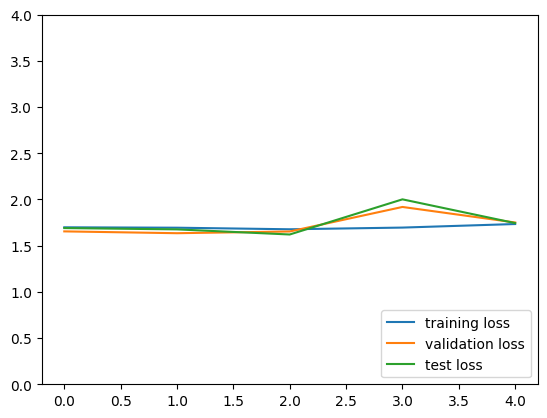

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.plot(test_loss, label='test loss')
plt.legend(loc='lower right')
plt.ylim(0,4)
plt.show()

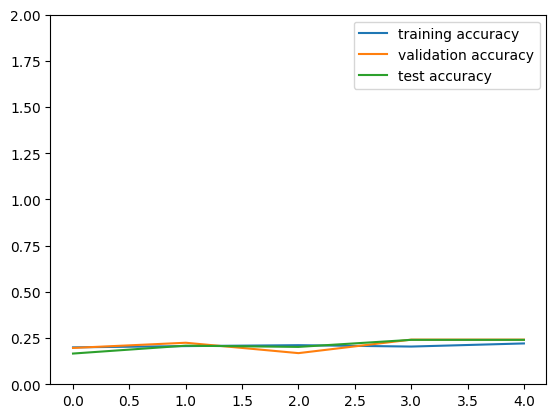

In [ ]:
plt.plot(train_acc, label='training accuracy')
plt.plot(validation_acc, label='validation accuracy')
plt.plot(test_acc, label='test accuracy')
plt.legend(loc='upper right')
plt.ylim(0,2)
plt.show()